In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic
import itertools as it
import seaborn as sns
import time
from scipy.stats import norm

In [3]:

def target_function_a(x1, x2, x3):
    return np.sin(5 * x1) * np.cos(7 * x2) * np.sin(3 * x3)

# Function b) Contamination detection-like target function
def target_function_b(x1, x2, x3):
    mode1 = np.exp(-((x1 - 0.2)**2 + (x2 - 0.3)**2 + (x3 - 0.4)**2) / 0.01)
    mode2 = np.exp(-((x1 - 0.8)**2 + (x2 - 0.7)**2 + (x3 - 0.6)**2) / 0.001)
    return mode1 + mode2

def target_function_c(x1, x2, x3):
    return np.sin(5 * x1) * np.cos(7 * x2) * np.sin(3 * x3) + np.random.normal(0, 0.1)

def target_function_d(x1, x2, x3):
    """
    A more complex target function for a black box optimization problem.
    """
    if len([x1, x2, x3]) != 3:
        raise ValueError("Expected 3 inputs: x1, x2, x3")
    
    # Base trigonometric combination with a different structure
    trig_combination = np.cos(3 * x1) * np.sin(4 * x2) * np.cos(5 * x3)
    
    # Add a harmonic term
    harmonic_term = np.sin(10 * (x1 + x2)) * np.cos(7 * (x2 + x3))
    
    # Add some random noise
    noise = np.random.normal(0, 0.1)

    # Combine components
    return trig_combination + harmonic_term + noise

In [4]:
# Define acquisition functions
def acquisition_ucb(gpr_model, x, beta):
    mean, std = gpr_model.predict(x, return_std=True)
    return mean + beta * std

def acquisition_ei(gpr_model, x, best_y):
    mean, std = gpr_model.predict(x, return_std=True)
    z = (mean - best_y) / (std + 1e-9)
    return std * (z * norm.cdf(z) + norm.pdf(z))

def acquisition_pi(gpr_model, x, best_y, xi=0.01):
    mean, std = gpr_model.predict(x, return_std=True)
    z = (mean - best_y - xi) / (std + 1e-9)
    return norm.cdf(z)

In [5]:
def generate_samples(target_func, num_samples):
    np.random.seed(0)
    inputs = np.random.rand(num_samples, 3)
    outputs = [target_func(*inp) for inp in inputs]
    df = pd.DataFrame(inputs, columns=['Input1', 'Input2', 'Input3'])
    df['Output'] = outputs
    return df

In [6]:
#ELIGE LA FUNCION

target_function=target_function_b

In [7]:
#GENERA EL GRID REAL

target_func=target_function

grid=25

# Create a grid of inputs
x1 = np.linspace(0, 1, grid)
x2 = np.linspace(0, 1, grid)
x3 = np.linspace(0, 1, grid)
inputs = np.array(np.meshgrid(x1, x2, x3)).T.reshape(-1, 3)

# Generate outputs
outputs = [target_func(*inp) for inp in inputs]
df = pd.DataFrame(inputs, columns=['Input1', 'Input2', 'Input3'])
df['Output'] = outputs

In [8]:
# Display basic statistics
print("Basic Statistical Summary:")
print(df.describe())

Basic Statistical Summary:
             Input1        Input2        Input3        Output
count  15625.000000  15625.000000  15625.000000  1.562500e+04
mean       0.500000      0.500000      0.500000  5.078297e-03
std        0.300472      0.300472      0.300472  4.206712e-02
min        0.000000      0.000000      0.000000  1.950393e-65
25%        0.250000      0.250000      0.250000  4.881540e-25
50%        0.500000      0.500000      0.500000  3.019981e-16
75%        0.750000      0.750000      0.750000  8.208829e-09
max        1.000000      1.000000      1.000000  9.591895e-01


In [9]:
max_index = np.argmax(outputs)
max_coords = inputs[max_index]
max_value = outputs[max_index]

max_coords,max_value

print("Funcion real")
print("-------------")
print("MAX VALUE: ", round(max_value,6))
print("    ")
print(" Input 1:  ", round(max_coords[0],6))
print(" Input 2:  ", round(max_coords[1],6))
print(" Input 3:  ", round(max_coords[2],6))

Funcion real
-------------
MAX VALUE:  0.959189
    
 Input 1:   0.208333
 Input 2:   0.291667
 Input 3:   0.416667


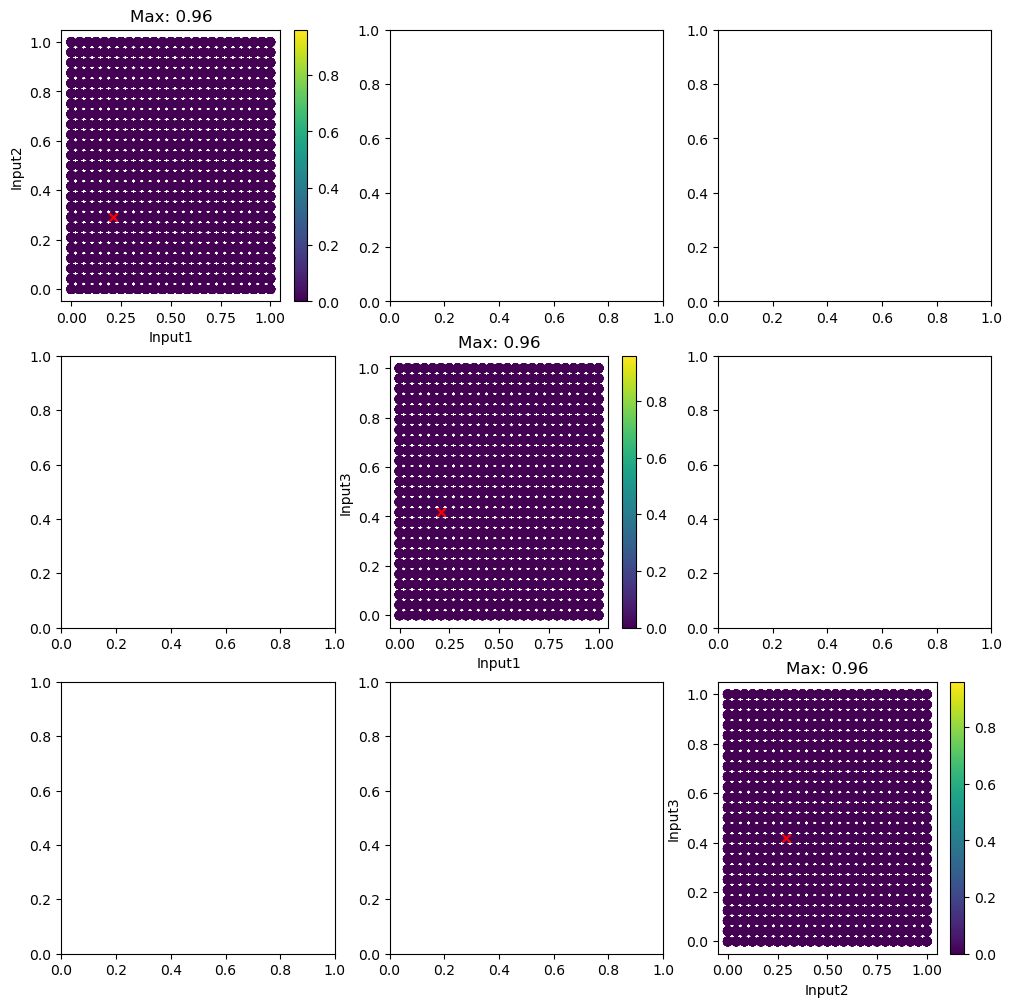

In [10]:
# Plot pairwise scatter plots with colors indicating output value
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
pairs = [(0, 1), (0, 2), (1, 2)]


for i, (x_idx, y_idx) in enumerate(pairs):
    sc = axs[i, i].scatter(df[f'Input{x_idx + 1}'], df[f'Input{y_idx + 1}'], c=df['Output'], cmap='viridis')
    axs[i, i].scatter(max_coords[x_idx], max_coords[y_idx], color='red', marker='x')
    axs[i, i].set_xlabel(f'Input{x_idx + 1}')
    axs[i, i].set_ylabel(f'Input{y_idx + 1}')
    axs[i, i].set_title(f'Max: {max_value:.2f}')

    fig.colorbar(sc, ax=axs[i, i], orientation='vertical')

plt.show()

In [11]:
#Muestra inicial

num_samples = 10

df = generate_samples(target_function, num_samples)
print(df)

     Input1    Input2    Input3        Output
0  0.548814  0.715189  0.602763  2.779221e-15
1  0.544883  0.423655  0.645894  3.502169e-09
2  0.437587  0.891773  0.963663  3.479385e-32
3  0.383442  0.791725  0.528895  2.070491e-13
4  0.568045  0.925597  0.071036  2.632305e-28
5  0.087129  0.020218  0.832620  8.296711e-13
6  0.778157  0.870012  0.978618  6.793170e-44
7  0.799159  0.461479  0.780529  9.729280e-24
8  0.118274  0.639921  0.143353  6.779988e-09
9  0.944669  0.521848  0.414662  5.891160e-27


In [13]:
# Step 4: Optimization Cycle with GP and Acquisition Function
#Use initial_df como el sample inicial


START_TIME=time.time()

num_samples=10
df = generate_samples(target_function, num_samples)

max_iterations=50

threshold=0.01
abs_real_max=max_value
    
noise_assumption = 1e-10 # noise assumption, a hyper-parameter (default 1e-10)
rbf_lengthscale = .1 # lengthscale parameter (default = 1), comenzaremos con 0.2 y luego ir descendiendo a 0.1 o menos

kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')

acquisition_function_name='ucb'

#Grid:
GG=25    #Numero de datos para cada variable en el Grid.  
dim=3    #Numero de Inputs

# Create a grid of values
x1 = np.linspace(0.000001, 0.999999, GG)     # Range for exploration
X_grid = np.fromiter(it.chain(*it.product(x1, repeat=dim)), dtype=float).reshape(-1, dim) # Generate all variables
# Convert X_grid into a DataFrame with meaningful names
X_grid = pd.DataFrame(X_grid, columns=['Input1', 'Input2', 'Input3'])

records = []
records_df=[]

for iteration in range(max_iterations):
    
    # Fit GP model
    gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)
    gpr_model.fit(df[['Input1', 'Input2', 'Input3']], df['Output'])
    mean, std = gpr_model.predict(X_grid, return_std = True)

    #Acquisition function
    #######################################################
    if acquisition_function_name == 'ucb':
        beta = max(2.5 - 0.1 * iteration, 0.5)
        acquisition_function=acquisition_ucb(gpr_model, X_grid, beta)
    elif acquisition_function_name == 'ei':
        best_y = df['Output'].max()
        acquisition_function=acquisition_ei(gpr_model,  X_grid, best_y)
    elif acquisition_function_name == 'pi':
        best_y = df['Output'].max()
        acquisition_function=acquisition_pi(gpr_model,  X_grid, best_y,xi=0.01)
    #######################################################
    idx_max = np.argmax(acquisition_function)
    next_query = X_grid.iloc[idx_max] # Access row by index


    #*** ADD Random component to the query to make sure it doesn't get's stucked
    # Add a small random perturbation to each dimension
    #next_query += np.random.normal(0, 0.01, 3)  # Adjust standard deviation as needed
    # Ensure values are within [0, 1] range
    #next_query = np.clip(next_query, 0, 1)
    
    
    # Evaluate the real target function
    next_output = target_func(*next_query.to_numpy()) # Convert row to numpy array

    # Update DataFrame
    df.loc[len(df)] = [*next_query, next_output]

    # Distance to max
    distance_to_max = abs_real_max-next_output
    formatted_next_query = '-'.join(f"{x:.4f}" for x in next_query)
    records.append([iteration + 1, formatted_next_query, next_output, gpr_model.kernel_,noise_assumption, beta, distance_to_max])

    #print(f"Finished iteration {iteration+1}")
          
    # Check convergence
    if distance_to_max < threshold:
        print(f"Converged to maximum at iteration {iteration + 1}")
        break

records_df = pd.DataFrame(records, columns=['Iteration', 'Inputs', 'Output', 'Model Parameters','Noise assum','Beta', 'Distance to Max'])

#Medir el tiempo consumido
END_TIME=time.time()
elapsed_time=END_TIME-START_TIME

# Print details
print(f"Steps: {len(records_df)}")
print(f"Distance to max: {distance_to_max:.6f}")
print(" ")
print(f"Kernel Parameters: {gpr_model.kernel_}")
print(f"Noise assumption: {noise_assumption:.1e}")
print(f"Acquisition Function: UCB, beta={beta}")
print(f"Acquisition Function Model: {acquisition_function_name}")
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(" ")

# Retrieve the last row
last_row = df.tail(1)

# Alternatively, for a more readable format:
print("\nLast Row:")
for col in last_row.columns:
    print(f"{col}: {last_row[col].values[0]:.6f}")


Converged to maximum at iteration 21
Steps: 21
Distance to max: 0.000001
 
Kernel Parameters: RBF(length_scale=0.1)
Noise assumption: 1.0e-10
Acquisition Function: UCB, beta=0.5
Acquisition Function Model: ucb
Elapsed time: 0.659712 seconds
 

Last Row:
Input1: 0.208334
Input2: 0.291667
Input3: 0.416667
Output: 0.959189


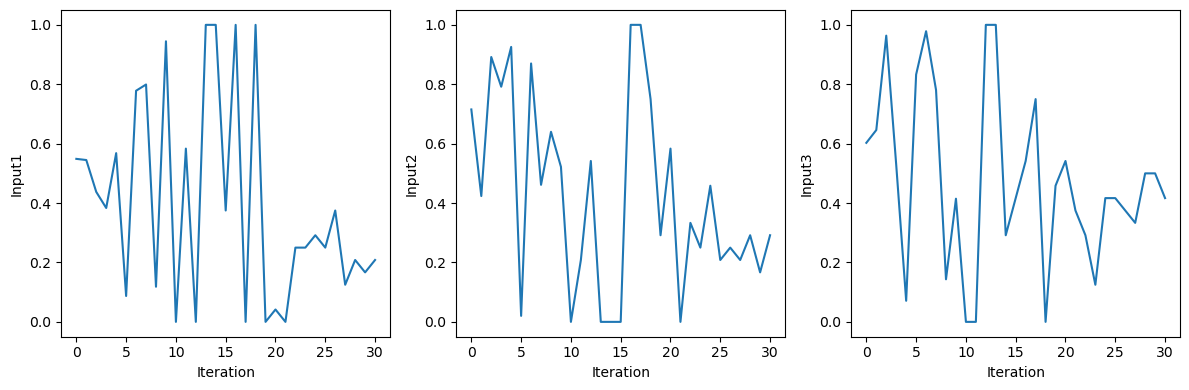

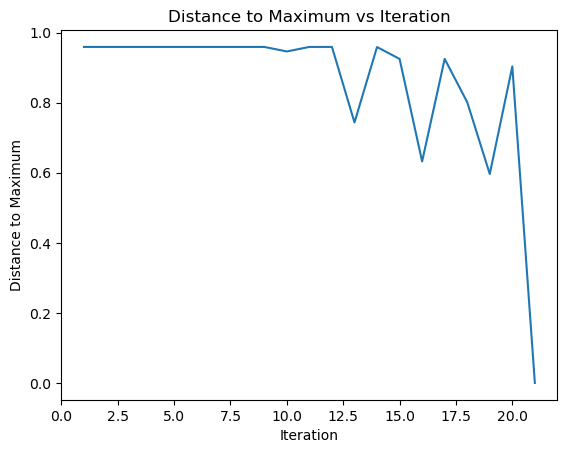

In [14]:
# Step 7: Chart evolution of inputs and distance to max
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(df[f'Input{i + 1}'])
    plt.xlabel('Iteration')
    plt.ylabel(f'Input{i + 1}')
plt.tight_layout()
plt.show()

plt.plot(records_df['Iteration'], records_df['Distance to Max'])
plt.xlabel('Iteration')
plt.ylabel('Distance to Maximum')
plt.title('Distance to Maximum vs Iteration')
plt.show()

In [271]:
#*********************************************

In [272]:
#************************************************************************
# Definido como proceso para correr varios a la vez

### Alternative RBF Setups

1. **Length Scale Bounds:** Instead of using `'fixed'` length scale bounds, you can set specific bounds as tuples:

   ```python
   kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds=(1e-2, 1e1))
   ```

   This allows the model to adapt its sensitivity to different ranges, which can help in both exploratory and exploitative phases of the optimization process.

2. **Additive White Noise:** In practice, noise is often present in the data. You can model this directly by combining an RBF kernel with a WhiteKernel:

   ```python
   from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel

   kernel = ConstantKernel(1.0) * RBF(length_scale=rbf_lengthscale) + WhiteKernel(noise_level=1e-3)
   ```

   This setup can model both the general shape of the function and any underlying noise, making it more robust in real-world scenarios.

### Non-RBF Kernel Setups

1. **Matern Kernel:**

   The Matern kernel is a popular choice for Gaussian processes, especially for functions with irregular or complex shapes. The parameter `nu` controls the smoothness of the function:

   ```python
   from sklearn.gaussian_process.kernels import Matern

   kernel = Matern(length_scale=rbf_lengthscale, nu=1.5)
   ```

   - **Pros:** The Matern kernel is more flexible than the RBF kernel, allowing for varying levels of smoothness. By adjusting the `nu` parameter, you can explore functions that range from linear to highly smooth.
   - **Cons:** While flexible, Matern can be slower to optimize and may require more iterations, particularly for `nu` values that yield complex functions.

   You can explore different values of `nu`:

   - `nu = 1.5` for moderate smoothness.
   - `nu = 2.5` for higher smoothness.

2. **Rational Quadratic Kernel:**

   This kernel models functions as a weighted sum of RBF kernels with different length scales, which allows it to handle functions with varying levels of smoothness across different parts of the input space:

   ```python
   from sklearn.gaussian_process.kernels import RationalQuadratic

   kernel = RationalQuadratic(length_scale=rbf_lengthscale, alpha=0.5)
   ```

   - **Pros:** The Rational Quadratic kernel is more versatile than the RBF kernel, handling both global trends and localized variations efficiently.
   - **Cons:** It may require more tuning to optimize the `alpha` parameter, which controls the balance between global trends and localized variations.

   You can explore different values of `alpha`:

   - `alpha = 0.5` for moderate flexibility.
   - `alpha = 1.0` for higher flexibility.

In summary, the Matern and Rational Quadratic kernels offer flexibility beyond the RBF kernel, with the former allowing for different levels of smoothness and the latter handling varying scales across different parts of the function. Both options require careful tuning but provide robust modeling capabilities for real-world functions.

In [30]:
# noise_assumption = 1e-10 # noise assumption, a hyper-parameter (default 1e-10)
# rbf_lengthscale = .1 # lengthscale parameter (default = 1), comenzaremos con 0.2 y luego ir descendiendo a 0.1 o menos
# kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')

def proceso(acquisition_function_name,printt):
# Entra el tipo de acquisition function: --- ucb, ei, pi ---
# printt es para ver cuanta informacion imprime. 'PArcial' o 'Total'

    START_TIME=time.time()

    max_iterations=50

    threshold=0.01 #cuando detener el proceso
    abs_real_max=max_value


    #Grid:
    GG=25    #Numero de datos para cada variable en el Grid.  
    dim=3    #Numero de Inputs

    # Create a grid of values
    x1 = np.linspace(0.000001, 0.999999, GG)     # Range for exploration
    X_grid = np.fromiter(it.chain(*it.product(x1, repeat=dim)), dtype=float).reshape(-1, dim) # Generate all variables
    # Convert X_grid into a DataFrame with meaningful names
    X_grid = pd.DataFrame(X_grid, columns=['Input1', 'Input2', 'Input3'])

    records = []
    records_df=[]

    for iteration in range(max_iterations):

        # Fit GP model
        gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)
        gpr_model.fit(df[['Input1', 'Input2', 'Input3']], df['Output'])
        mean, std = gpr_model.predict(X_grid, return_std = True)

        #Acquisition function
        #######################################################
        if acquisition_function_name == 'ucb':
            beta = max(2.5 - 0.1 * iteration, 0.5)
            acquisition_function=acquisition_ucb(gpr_model, X_grid, beta)
        elif acquisition_function_name == 'ei':
            best_y = df['Output'].max()
            acquisition_function=acquisition_ei(gpr_model,  X_grid, best_y)
        elif acquisition_function_name == 'pi':
            best_y = df['Output'].max()
            acquisition_function=acquisition_pi(gpr_model,  X_grid, best_y,xi=0.01)
        #######################################################
        idx_max = np.argmax(acquisition_function)
        next_query = X_grid.iloc[idx_max] # Access row by index


        #*** ADD Random component to the query to make sure it doesn't get's stucked
        # Add a small random perturbation to each dimension
        #next_query += np.random.normal(0, 0.01, 3)  # Adjust standard deviation as needed
        # Ensure values are within [0, 1] range
        #next_query = np.clip(next_query, 0, 1)


        # Evaluate the real target function
        next_output = target_func(*next_query.to_numpy()) # Convert row to numpy array

        # Update DataFrame
        df.loc[len(df)] = [*next_query, next_output]

        # Distance to max
        distance_to_max = abs_real_max-next_output
        formatted_next_query = '-'.join(f"{x:.4f}" for x in next_query)
        records.append([iteration + 1, formatted_next_query, next_output, gpr_model.kernel_,noise_assumption, beta, distance_to_max])

        #print(f"Finished iteration {iteration+1}")

        # Check convergence
        if distance_to_max < threshold:
            print(f"Converged to maximum at iteration {iteration + 1}")
            break

    records_df = pd.DataFrame(records, columns=['Iteration', 'Inputs', 'Output', 'Model Parameters','Noise assum','Beta', 'Distance to Max'])

    #Medir el tiempo consumido
    END_TIME=time.time()
    elapsed_time=END_TIME-START_TIME

    # Retrieve the last row
    last_row = df.tail(1)
    
    # Print details
    
    if printt=='Total':
        print(f"Steps: {len(records_df)}")
        print(f"Distance to max: {distance_to_max:.6f}")
        print(" ")
        print(f"Kernel Parameters: {gpr_model.kernel_}")
        print(f"Noise assumption: {noise_assumption:.1e}")
        print(f"Acquisition Function: UCB, beta={beta}")
        print(f"Acquisition Function Model: {acquisition_function_name}")
        print(f"Elapsed time: {elapsed_time:.6f} seconds")
        print(" ")
        print("\nLast Row:")
        for col in last_row.columns:
            print(f"{col}: {last_row[col].values[0]:.6f}")
    else:
        print(f"Steps: {len(records_df)}")
        print(f"Kernel Parameters: {gpr_model.kernel_}")
        print(f"Acquisition Function Model: {acquisition_function_name}")
        print(f"Elapsed time: {elapsed_time:.6f} seconds")
        print(f"Output: {last_row['Output'].values[0]:.6f}")
        print(" ")
    
    #Develve el detalle de todo el proceso
    return records_df


In [31]:
noise_assumption = 1e-10 # noise assumption, a hyper-parameter (default 1e-10)
rbf_lengthscale = .1 # lengthscale parameter (default = 1), comenzaremos con 0.2 y luego ir descendiendo a 0.1 o menos
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')

records_df=proceso('ucb','Total')

Converged to maximum at iteration 21
Steps: 21
Distance to max: 0.000001
 
Kernel Parameters: RBF(length_scale=0.1)
Noise assumption: 1.0e-10
Acquisition Function: UCB, beta=0.5
Acquisition Function Model: ucb
Elapsed time: 0.642118 seconds
 

Last Row:
Input1: 0.208334
Input2: 0.291667
Input3: 0.416667
Output: 0.959189


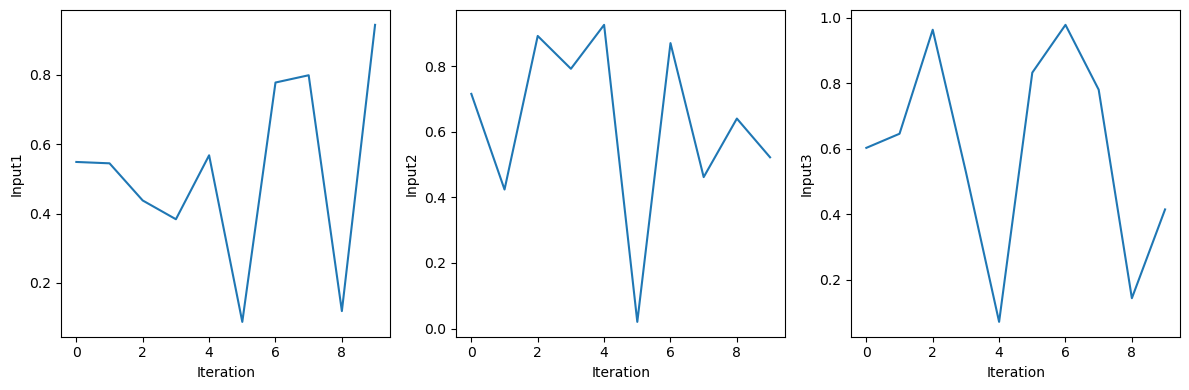

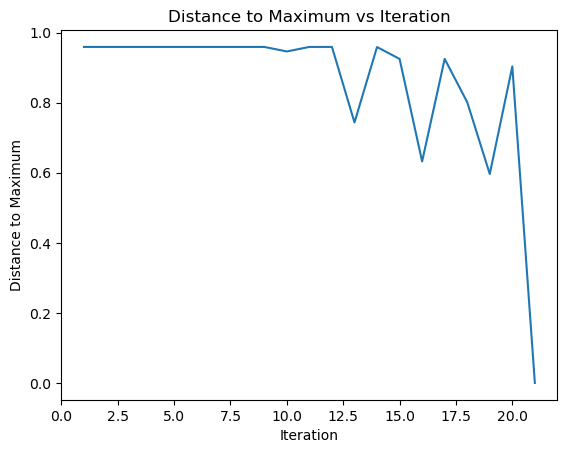

In [32]:
# Step 7: Chart evolution of inputs and distance to max
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(df[f'Input{i + 1}'])
    plt.xlabel('Iteration')
    plt.ylabel(f'Input{i + 1}')
plt.tight_layout()
plt.show()

plt.plot(records_df['Iteration'], records_df['Distance to Max'])
plt.xlabel('Iteration')
plt.ylabel('Distance to Maximum')
plt.title('Distance to Maximum vs Iteration')
plt.show()

In [33]:
max_iterations=50    #Numero maximo de interaciones

threshold=0.001
abs_real_max=max_value
num_samples=10 #numero de samples inicial

noise_exp=[1e-4,1e-6,1e-10]
rbf_lenght_exp=[1,.3,.2,.1]

for no in noise_exp:
    for le in rbf_lenght_exp:
        noise_assumption = no # noise assumption, a hyper-parameter (default 1e-10)
        rbf_lengthscale = le # lengthscale parameter (default = 1), comenzaremos con 0.2 y luego ir descendiendo a 0.1 o menos
        kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
        #*******
        df = generate_samples(target_function, num_samples)
        records_df=proceso('ucb','Parcial')
                

Steps: 50
Kernel Parameters: RBF(length_scale=1)
Acquisition Function Model: ucb
Elapsed time: 2.391485 seconds
Output: 0.123652
 
Steps: 50
Kernel Parameters: RBF(length_scale=0.3)
Acquisition Function Model: ucb
Elapsed time: 1.994213 seconds
Output: 0.000000
 
Steps: 50
Kernel Parameters: RBF(length_scale=0.2)
Acquisition Function Model: ucb
Elapsed time: 2.178290 seconds
Output: 0.000000
 
Converged to maximum at iteration 21
Steps: 21
Kernel Parameters: RBF(length_scale=0.1)
Acquisition Function Model: ucb
Elapsed time: 0.658522 seconds
Output: 0.959189
 
Steps: 50
Kernel Parameters: RBF(length_scale=1)
Acquisition Function Model: ucb
Elapsed time: 2.139057 seconds
Output: 0.090468
 
Steps: 50
Kernel Parameters: RBF(length_scale=0.3)
Acquisition Function Model: ucb
Elapsed time: 2.448584 seconds
Output: 0.000000
 
Steps: 50
Kernel Parameters: RBF(length_scale=0.2)
Acquisition Function Model: ucb
Elapsed time: 2.307102 seconds
Output: 0.000000
 
Converged to maximum at iteration 21